# Load Training Data

In [1]:
%load_ext autoreload
%autoreload 2

Number of trajectories:  2
Number of states:  3
Number of inputs:  3
Number of each points:  [35. 32.]


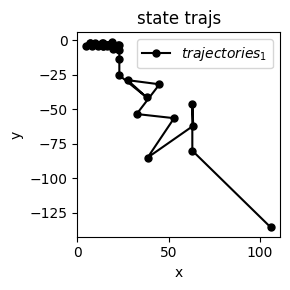

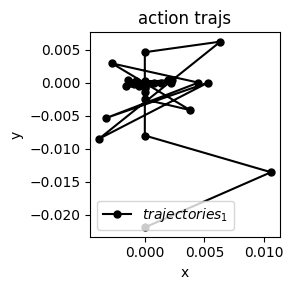

[[ 106.    63.    63.    63.5]
 [-135.5  -80.   -46.   -62. ]]
[[ 0.       0.0106   0.       0.     ]
 [-0.0219  -0.01355 -0.008    0.0046 ]]


In [12]:
from robot_tools.trajer import TrajTools, recorder, TrajsPainter
data2 = recorder.json_process("data_sim_1.json")
data = recorder.json_process("data_sim_2.json")
data["1"] = data2["0"]  # 增加data轨迹

(obs_trajs, raw_state_info) = TrajTools.construct_trajs(
    data, key="observation", series_type="h", mixed_type="h"
)

(act_trajs, raw_act_info) = TrajTools.construct_trajs(
    data, key="action", series_type="h", mixed_type="h"
)

print("Number of trajectories: ", raw_state_info.trajs_num)
print("Number of states: ", raw_state_info.features_num)
print("Number of inputs: ", raw_act_info.features_num)
print("Number of each points: ", raw_state_info.each_points_num)

# Training data
RAW_STATE_MIXED = obs_trajs[2]
RAW_ACTION_MIXED = act_trajs[2]
RAW_STATE_SERIES = obs_trajs[1][:2,:]
RAW_ACTION_SERIES = act_trajs[1][:2,:]
assert RAW_STATE_MIXED.shape == RAW_ACTION_MIXED.shape
assert RAW_ACTION_SERIES.shape == RAW_STATE_SERIES.shape

# draw
show_points_num = 30
raw_state_painter = TrajsPainter(RAW_STATE_MIXED, raw_state_info)
raw_state_painter.figure_size_2D = (3, 3)
raw_state_painter.features_axis_labels = ["x", "y", "yaw"]
raw_state_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), title="state trajs")
raw_act_painter = TrajsPainter(RAW_ACTION_MIXED, raw_act_info)
raw_act_painter.figure_size_2D = (3, 3)
raw_act_painter.features_axis_labels = ["x", "y", "yaw"]
raw_act_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), title="action trajs")

print(RAW_STATE_SERIES[:, 0:4])
print(RAW_ACTION_SERIES[:, 0:4])

# Koopman using EDMDc

## Training

In [2]:
import pykoopman as pk
import warnings
import numpy as np
np.random.seed(42)  # for reproducibility
warnings.filterwarnings("ignore")
from pykoopman.regression import EDMDc
from pykoopman.observables import RadialBasisFunction, Polynomial

[[ 106.    63.    63.    63.5]
 [-135.5  -80.   -46.   -62. ]]
[[ 0.0106   0.       0.       0.00635]
 [-0.01355 -0.008    0.0046   0.0062 ]]
[[ 63.   63.   63.5  38.5]
 [-80.  -46.  -62.  -85. ]]

[[ 7.          9.5        13.42962646 19.02911377]
 [-2.         -2.5        -1.90344238 -1.14801025]]
[[-0.0007     -0.00095    -0.00134296  0.        ]
 [ 0.0002     -0.00025     0.          0.0001148 ]]
[[ 9.5        13.42962646 19.02911377 18.95172119]
 [-2.5        -1.90344238 -1.14801025 -0.5401001 ]]


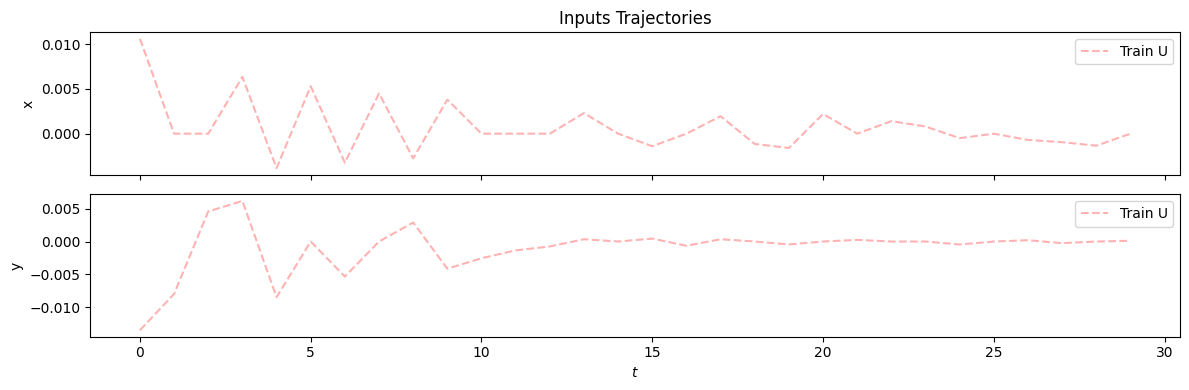

In [14]:
points_num = 30
start_point = 0
end_point = int(start_point + points_num)
trajs = (0,)
assert end_point <= raw_state_info.each_points_num[0]
raw_state_info.features_num = 2
raw_act_info.features_num = 2
X, X_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES, raw_state_info, (start_point, end_point), trajs
)
Y, Y_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES,
    raw_state_info,
    (start_point + 1, int(start_point + points_num) + 1),
    trajs,
)
U, U_info = TrajTools.get_sub_series_trajs(
    RAW_ACTION_SERIES,
    raw_act_info,
    (start_point + 1, int(start_point + points_num) + 1),
    trajs,
)

print(X[:, :4])
print(U[:, :4])
print(Y[:, :4])
print("")
print(X[:, -4:])
print(U[:, -4:])
print(Y[:, -4:])

u_painter = TrajsPainter(U, U_info)
u_painter.features_sharetitle = "Inputs Trajectories"
u_painter.features_self_labels = "Train U"
u_painter.features_lines = "--r"
u_painter.features_axis_labels = ["x", "y", "yaw"]
u_painter.plot_features_with_t((0, points_num), (0,), (0, 1))


In [15]:
EDMDc_ = EDMDc()
rbf_type = "gauss"  # 'thinplate' polyharmonic gauss invquad invmultquad
regressor = RadialBasisFunction(
    rbf_type=rbf_type,
    n_centers=10,
    centers=None,
    kernel_width=1.0,
    polyharmonic_coeff=2.0,
    include_state=True,
)
# regressor = Polynomial(degree=2)

model = pk.Koopman(observables=regressor, regressor=EDMDc_)
model.fit(X.T, y=Y.T, u=U.T)

Koopman(observables=RadialBasisFunction(centers=array([[  65.84056094,   16.82873303,    5.        ,  104.12188229,
         106.        ,   88.3661469 ,   31.86687243,    8.65838794,
          74.44113152,   47.06752589],
       [-122.04076541,  -64.7426779 , -135.5       ,   -1.14801025,
        -101.04310129,  -39.04560995,  -92.91515668,  -60.92047143,
         -56.82936391, -112.39488963]]),
                                        polyharmonic_coeff=2.0),
        regressor=EDMDc())

In [16]:
# 在训练集上回归
# 这里因为只有一个轨迹，所以采用了简化的方式
Xtrain = X
x0 = X[:, 0][np.newaxis, :]

print(x0)
print(U.shape)

Xkoop = model.simulate(x0, U.T, n_steps=points_num - 1)
Xkoop = np.vstack([x0, Xkoop])  # add initial point
Xkoop = Xkoop.T

[[ 106.  -135.5]]
(2, 30)


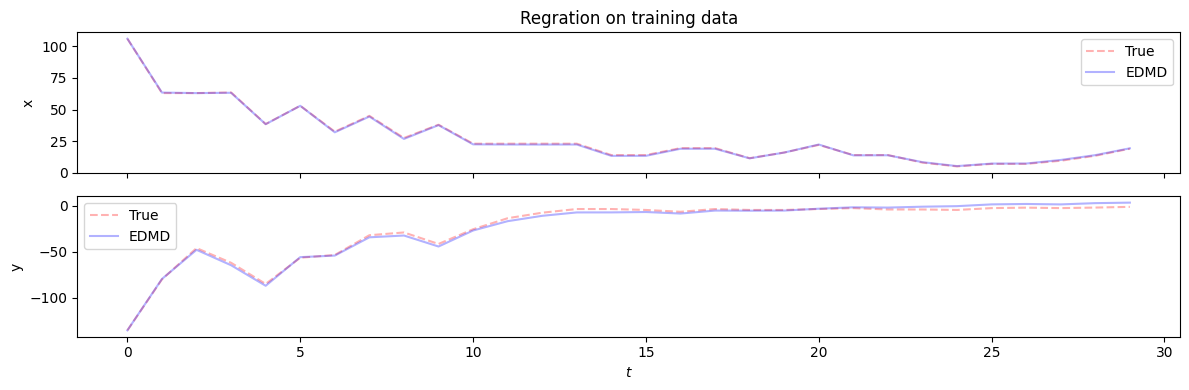

In [19]:
# 绘图
from robot_tools.trajer import TrajInfo

max_train_draw = 30
Xkoop_info = Xtrain_info = TrajInfo.consruct(
    Xtrain,
    "series_h",
    1,
)

trajs_painter = TrajsPainter()
trajs_painter.update_trajs(Xtrain, Xtrain_info)
trajs_painter.features_self_labels = "True"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Regration on training data"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
axs = trajs_painter.plot_features_with_t(
    (0, max_train_draw), (0,), (0, 1), return_axs=True
)

trajs_painter.update_trajs(Xkoop, Xkoop_info)
trajs_painter.features_self_labels = "EDMD"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, max_train_draw), (0,), (0, 1), given_axs=axs)

In [20]:
# 在训练集上预测
x = Xtrain[:, 0][np.newaxis, :]
n_traj = 1
Xk = Xtrain_info.get_trajs("mixed_h")
Yk = Xtrain_info.get_trajs("mixed_h")

for k in range(Xtrain_info.max_points_num):
    yT = model.predict(x, U[:, k])
    Xk[:, k*n_traj:(k+1)*n_traj] = x.T
    Yk[:, k*n_traj:(k+1)*n_traj] = yT.T
    x = yT
assert TrajTools.has_nan(Xk) == False, "Xk has nan"
assert TrajTools.has_nan(Yk) == False, "Yk has nan"

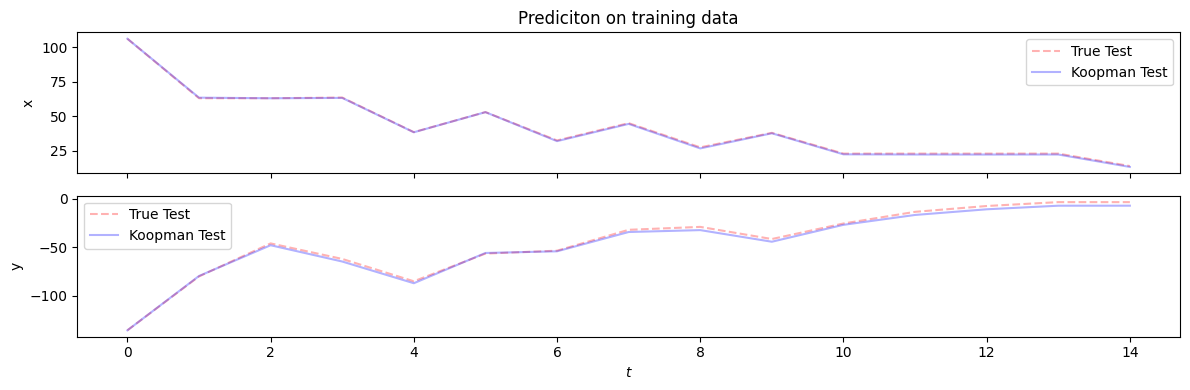

In [22]:
# max_points_num = train_points_num
max_points_num = 15

Xk_info = Xtrain_info

trajs_painter = TrajsPainter()
trajs_painter.update_trajs(Xtrain, Xtrain_info)
trajs_painter.features_self_labels = "True Test"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Prediciton on training data"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
axs = trajs_painter.plot_features_with_t(
    (0, max_points_num), (0,), (0, 1), return_axs=True
)

trajs_painter.update_trajs(Xk, Xk_info)
trajs_painter.features_self_labels = "Koopman Test"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, max_points_num), (0,), (0, 1), given_axs=axs)

## Testing

Number of trajectories:  1
Number of states:  3
Number of inputs:  3
Number of each points:  [32.]
[[207.04348755 117.58218384  99.50003052  99.5       ]
 [127.30657959 119.78076172  73.5         73.5       ]]
[[0.         0.02070435 0.01175822 0.        ]
 [0.02043355 0.         0.         0.        ]]


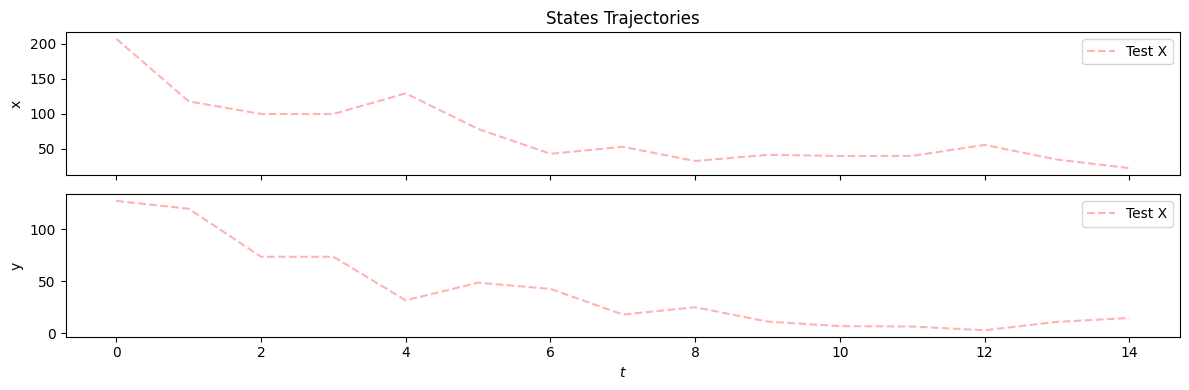

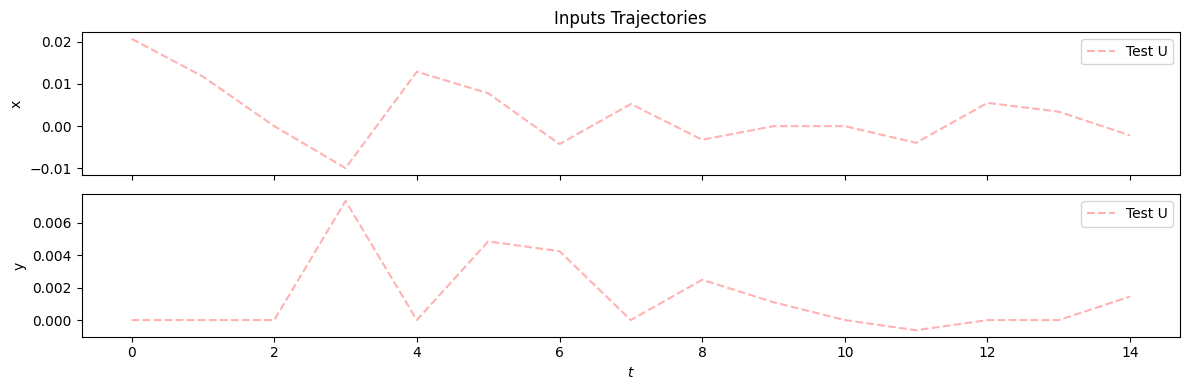

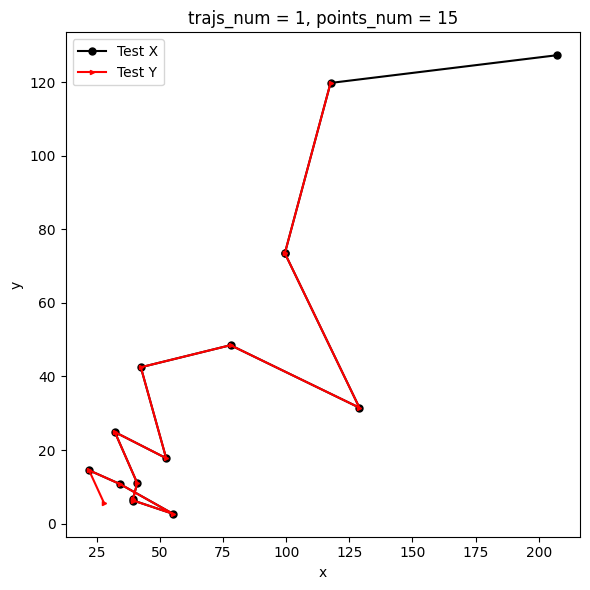

In [24]:
from robot_tools.trajer import TrajTools, recorder, TrajsPainter

data = recorder.json_process("data_sim_1.json")

(obs_trajs, raw_state_info) = TrajTools.construct_trajs(
    data, key="observation", series_type="h", mixed_type="h"
)

(act_trajs, raw_act_info) = TrajTools.construct_trajs(
    data, key="action", series_type="h", mixed_type="h"
)

print("Number of trajectories: ", raw_state_info.trajs_num)
print("Number of states: ", raw_state_info.features_num)
print("Number of inputs: ", raw_act_info.features_num)
print("Number of each points: ", raw_state_info.each_points_num)

# Training data
RAW_STATE_MIXED = obs_trajs[2]
RAW_ACTION_MIXED = act_trajs[2]
RAW_STATE_SERIES = obs_trajs[1][:2,:]
RAW_ACTION_SERIES = act_trajs[1][:2,:]
assert RAW_STATE_MIXED.shape == RAW_ACTION_MIXED.shape
assert RAW_ACTION_SERIES.shape == RAW_STATE_SERIES.shape

print(RAW_STATE_SERIES[:, 0:4])
print(RAW_ACTION_SERIES[:, 0:4])

points_num = 15
start_point = 0
end_point = int(start_point + points_num)
trajs = (0,)
assert end_point <= raw_state_info.each_points_num[0]
raw_state_info.features_num = 2
raw_act_info.features_num = 2
X_test, X_test_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES, raw_state_info, (start_point, end_point), trajs
)
Y_test, Y_test_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES,
    raw_state_info,
    (start_point + 1, int(start_point + points_num) + 1),
    trajs,
)
U_test, U_test_info = TrajTools.get_sub_series_trajs(
    RAW_ACTION_SERIES,
    raw_act_info,
    (start_point + 1, int(start_point + points_num) + 1),
    trajs,
)

show_points_num = points_num
trajs_painter = TrajsPainter()
trajs_painter.update_trajs(X_test, X_test_info)
trajs_painter.features_sharetitle = "States Trajectories"
trajs_painter.features_self_labels = "Test X"
trajs_painter.features_lines = "--r"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
trajs_painter.plot_features_with_t((0, show_points_num), (0,), (0, 1))
u_painter = TrajsPainter(U_test, U_test_info)
u_painter.features_sharetitle = "Inputs Trajectories"
u_painter.features_self_labels = "Test U"
u_painter.features_lines = "--r"
u_painter.features_axis_labels = ["x", "y", "yaw"]
u_painter.plot_features_with_t((0, show_points_num), (0,), (0, 1))

test_painter = TrajsPainter(X_test, X_test_info)
test_painter.trajs_labels = "Test X"
test_painter.features_axis_labels = ["x", "y", "yaw"]
axs = test_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), return_axs=True)
test_painter.update_trajs(Y_test, Y_test_info)
test_painter.trajs_labels = "Test Y"
test_painter.trajs_lines = "->r"
test_painter.trajs_markersize = 3
test_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), given_axs=axs)

In [25]:
# 在测试集上预测
n_traj = 1
x = X_test[:, 0][np.newaxis, :]
Xk = X_test_info.get_trajs("mixed_h")
Yk = X_test_info.get_trajs("mixed_h")

for k in range(int(X_test_info.max_points_num)):
    yT = model.predict(x, U_test[:, k])
    Xk[:, k * n_traj : (k + 1) * n_traj] = x.T
    Yk[:, k * n_traj : (k + 1) * n_traj] = yT.T
    x = yT
assert TrajTools.has_nan(Xk) == False, "Xk has nan"
assert TrajTools.has_nan(Yk) == False, "Yk has nan"
print(X_test[:, 0:3])
print(Xk[:, 0:3])

[[207.04348755 117.58218384  99.50003052]
 [127.30657959 119.78076172  73.5       ]]
[[207.04348755 127.33056554  82.58343166]
 [127.30657959 148.15453315 163.62338858]]


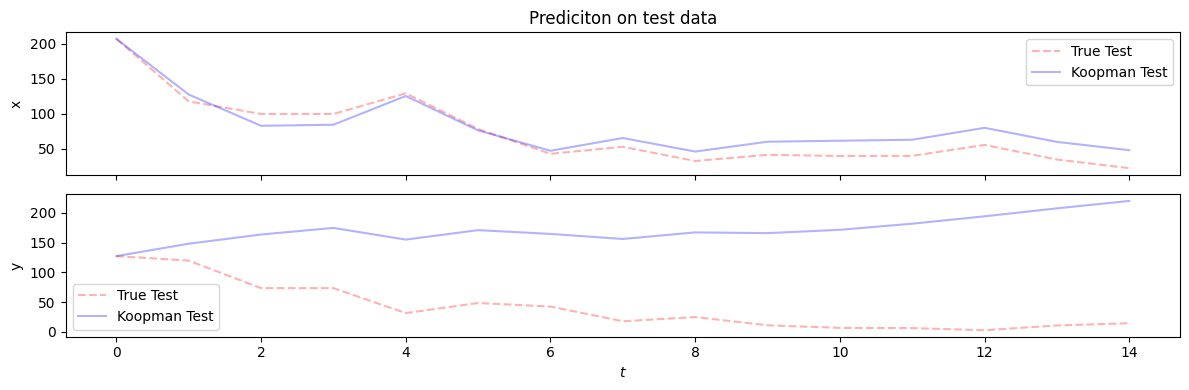

In [27]:
show_points_num = 15
trajs_painter = TrajsPainter()
trajs_painter.update_trajs(X_test, X_test_info)
trajs_painter.features_self_labels = "True Test"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Prediciton on test data"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
axs = trajs_painter.plot_features_with_t(
    (0, show_points_num), (0,), (0, 1), return_axs=True
)

trajs_painter.update_trajs(Xk, X_test_info)
trajs_painter.features_self_labels = "Koopman Test"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, show_points_num), (0,), (0, 1), given_axs=axs)
# trajs_painter.plot_features_with_t((0, 7), (0,), (0, 1, 2), given_axs=axs)

# 2D轨迹绘制

## Training

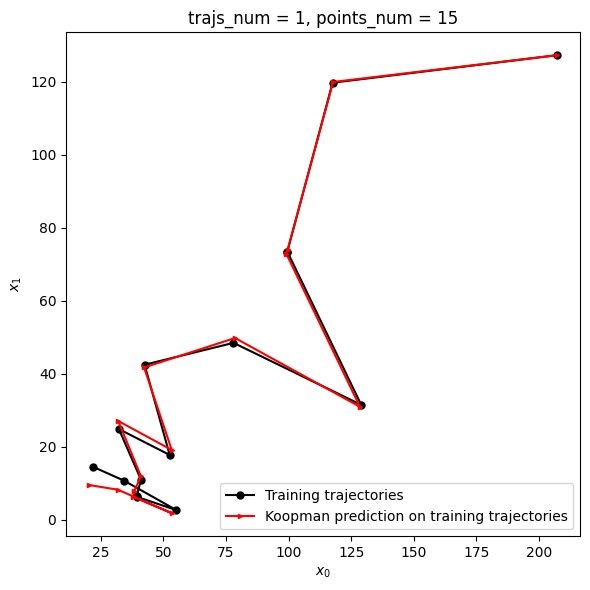

In [123]:
train_points_num = 15
raw_state_painter = TrajsPainter()
raw_state_painter.update_trajs(Xtrain, Xtrain_info)
raw_state_painter.trajs_labels = "Training trajectories"
axs = raw_state_painter.plot_2D_features((0, train_points_num), (0,), (0, 1), return_axs=True)
raw_state_painter.update_trajs(Xkoop, Xkoop_info)
raw_state_painter.trajs_labels = "Koopman prediction on training trajectories"
raw_state_painter.trajs_lines = "->r"
raw_state_painter.trajs_markersize = 3
raw_state_painter.plot_2D_features((0, train_points_num), (0,), (0, 1), given_axs=axs)

## Testing

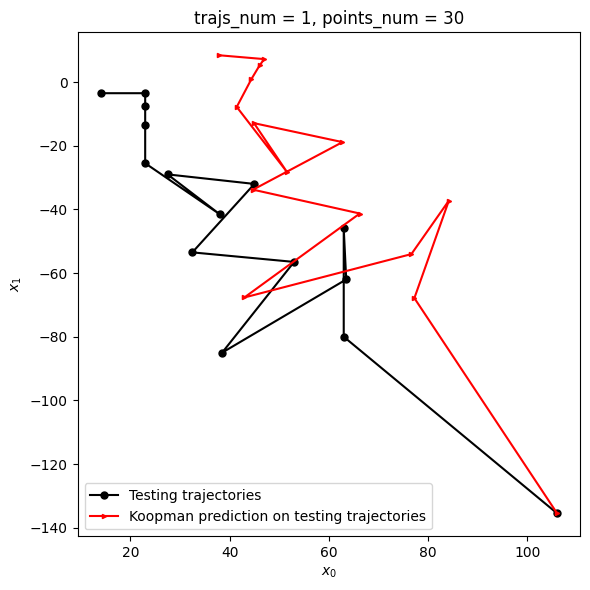

In [170]:
raw_state_painter = TrajsPainter()
raw_state_painter.update_trajs(X_test, X_test_info)
raw_state_painter.trajs_labels = "Testing trajectories"
axs = raw_state_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), return_axs=True)
raw_state_painter.update_trajs(Xk, X_test_info)
raw_state_painter.trajs_labels = "Koopman prediction on testing trajectories"
raw_state_painter.trajs_lines = "->r"
raw_state_painter.trajs_markersize = 3
raw_state_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), given_axs=axs)